In [1]:
from starter import *
from anneal import *
import math
import multiprocess as mp
import copy, random
from collections import defaultdict, Counter
import itertools
from bs4 import BeautifulSoup
import requests
from heapq import heapify, heappop, heappush
tar('outputs', overwrite = True)

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tar('outputs', overwrite = True)

In [2]:
def apply_pi(G, pi):
    num_v = len(G.nodes)
    assert num_v == len(pi)
    max_p = max(pi)

    p = list(Counter(pi))
    p.sort()
    map_p = {p[i]:i for i in range(len(p))}
    for v in range(num_v):
        G.nodes[v]['team'] = int(map_p[pi[v]] + 1)
    return G  

In [3]:
def get_all_low():
    f = open('all.txt', 'r')
    
    lines = f.readlines()
    names = []
    for line in lines:
        size, num = line.strip().split()
        names.append((size+num+'.in', size, num))
    return names
low_scores_all = get_all_low()
len(low_scores_all)

285

In [5]:
### Gets "optimal" score
target_scores = []
for filename, size, num in tqdm(low_scores_all):
    url='https://170-leaderboard.vercel.app/input/'+size+'/'+ num
    req=requests.get(url)
    content=req.text
    soup=BeautifulSoup(content)
    raw = soup.findAll('td')[5].text
    target = float(raw)+0.01
    target_scores.append([filename,target])

100%|██████████| 285/285 [01:40<00:00,  2.84it/s]


In [6]:
df = pd.read_csv('best_scores.csv')
for i in range(len(target_scores)):
    filename, target = target_scores[i][:2]
    approx = 2*np.log(target/100)
    k = math.floor(approx)
    r = df.index[df['name'] == filename]
    num_p = int(df.iloc[r]['k'])
    if abs(k-num_p) > 3:
        k = num_p
    target_scores[i] = [filename, str(target),str(k)]

In [7]:
f = open("target_soln_new.txt", "w")
for line in target_scores:
    f.write(line[0] + ' ' + line[1] + ' ' + line[2])
    f.write('\n')
f.close()

In [4]:
def write(instance, in_file, out_file, file_name, cost, k, overwrite):
    df = pd.read_csv('best_scores.csv')
    r = df.index[df['name'] == file_name]
    original = float(df.loc[r, 'score'])
    if cost < original:
        df.loc[r, 'score'] = cost
        df.loc[r, 'k'] = k
        df.to_csv('best_scores.csv', index=False)
        print(f"{str(in_file)}: cost", original, '->',score(instance))
        write_output(instance, out_file, overwrite)

In [5]:
df = pd.read_csv('best_scores.csv')
df2 = pd.read_csv('best_scores_first.csv')
files = [x for x in os.listdir('inputs') if x.endswith('.in')]
for file in tqdm(files):
    G = read_input('inputs/'+file)
    f_my = open(str(Path('outputs') / f"{file[:-len('.in')]}.out"))
    f_first = open(str(Path('outputs 2') / f"{file[:-len('.in')]}.out"))
    pi_my = json.load(f_my)
    apply_pi(G, pi_my)
    score_my = score(G)
    
    pi_first = json.load(f_first)
    apply_pi(G, pi_first)
    score_first = score(G)
    
    r = df.index[df['name'] == file]
    k = int(df.loc[r, 'k'])
    
    if score_first < score_my:
        write(G,'inputs/'+file,str(Path('outputs') / f"{file[:-len('.in')]}.out"), file, score_first,k, True)
    f_my.close()
    f_first.close()

  5%|▌         | 39/780 [00:00<00:17, 41.87it/s]

inputs/large163.in: cost 31481.80216654946 -> 31379.560881495607


 20%|█▉        | 154/780 [00:03<00:14, 41.88it/s]

inputs/large166.in: cost 23171.857658878635 -> 22149.617911531233


 22%|██▏       | 172/780 [00:03<00:10, 55.29it/s]

inputs/large224.in: cost 37926.69107937125 -> 37061.69464696912


 33%|███▎      | 260/780 [00:06<00:12, 41.72it/s]

inputs/small17.in: cost 2013.58953437996 -> 1976.0207180049056


 43%|████▎     | 335/780 [00:07<00:10, 43.18it/s]

inputs/medium223.in: cost 440502.6535340232 -> 439565.4145999371


 46%|████▌     | 360/780 [00:08<00:08, 48.45it/s]

inputs/medium134.in: cost 113729.55379323488 -> 110737.60995561059


 48%|████▊     | 373/780 [00:08<00:09, 41.03it/s]

inputs/small239.in: cost 1317.304596037192 -> 1304.4603010261908


 51%|█████     | 396/780 [00:09<00:07, 48.06it/s]

inputs/medium192.in: cost 159252.4223209113 -> 158376.97081429444


 54%|█████▍    | 422/780 [00:09<00:06, 51.35it/s]

inputs/large30.in: cost 34290.80216654946 -> 34188.56088149561
inputs/medium113.in: cost 68264.9267061148 -> 66374.858470326


 59%|█████▊    | 457/780 [00:10<00:05, 64.04it/s]

inputs/medium166.in: cost 54435.59297944166 -> 52312.01354045731
inputs/medium224.in: cost 34365.70364765726 -> 31864.75995541052


 65%|██████▌   | 510/780 [00:11<00:04, 63.45it/s]

inputs/medium156.in: cost 227364.98008567136 -> 227269.9800856715
inputs/small92.in: cost 270828.01581064693 -> 270652.01581064693


 66%|██████▋   | 518/780 [00:11<00:04, 53.60it/s]

inputs/medium240.in: cost 96071.74944955336 -> 93181.48515159641


 68%|██████▊   | 531/780 [00:11<00:05, 47.97it/s]

inputs/medium163.in: cost 87557.74944954777 -> 83461.4851515964
inputs/medium132.in: cost 99737.49225722316 -> 98568.74944956275


 74%|███████▍  | 576/780 [00:12<00:03, 63.77it/s]

inputs/large238.in: cost 739.905609893065 -> 449.2277266951576


 78%|███████▊  | 608/780 [00:13<00:04, 42.11it/s]

inputs/medium119.in: cost 30247.913986133608 -> 29431.301923425952
inputs/medium71.in: cost 149443.1330647236 -> 141920.1963397978


 96%|█████████▋| 751/780 [00:16<00:00, 48.66it/s]

inputs/small157.in: cost 99255.15500661256 -> 98952.1881231363


 98%|█████████▊| 767/780 [00:16<00:00, 55.72it/s]

inputs/medium159.in: cost 21280.77278818516 -> 21250.772788185157


100%|██████████| 780/780 [00:16<00:00, 47.07it/s]


In [11]:
### Naive Partitioner
for file, cost_tar, k_tar in targets:    
    G = read_input('inputs/'+file)
    out_dir = str(Path('outputs') / f"{file[:-len('.in')]}.out")
    in_dir = 'inputs/'+file
    df = pd.read_csv('best_scores.csv')
    r = df.index[df['name'] == file]
    original_c = float(df.loc[r, 'score'])
    
    for k in range(2, 22):
        for v in G.nodes:
            G.nodes[v]['team'] = v % k + 1
        sc = score(G)
        if sc < original_c:
            write(G,'inputs/'+file,str(Path('outputs') / f"{file[:-len('.in')]}.out"), file, score_first,k, True)

In [9]:
file = 'large216.in'
G = read_input('inputs/'+file)
out_dir = str(Path('outputs') / f"{file[:-len('.in')]}.out")
in_dir = 'inputs/'+file
df = pd.read_csv('best_scores.csv')
r = df.index[df['name'] == file]
original_c = float(df.loc[r, 'score'])

for v in G.nodes:
    if v < 500:
        G.nodes[v]['team'] = 1
    else:
        G.nodes[v]['team'] = 2
score(G, separated=True)

(399200, 271.8281828459045, 1.0)

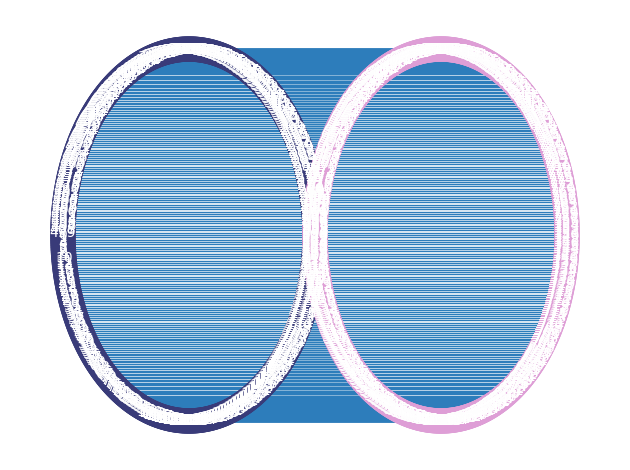

In [7]:
visualize(G)